# HiggsChallenge で GradientBoosting
このノートブックでは、scikit-learnのGradientBoostingを使って、HiggsChallengeデータセットの分類問題にトライします。


In [1]:
#ライブラリのインポート
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HiggsChallengeのデータセットは http://opendata.cern.ch/record/328 から入手できます。
```bash
$ wget http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
$ gunzip atlas-higgs-challenge-2014-v2.csv.gz
```

In [2]:
import pandas as pd
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")

In [3]:
X = df[[
    'DER_mass_MMC',
    'DER_mass_transverse_met_lep',
    'DER_mass_vis',
    'DER_pt_h',
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_deltar_tau_lep',
    'DER_pt_tot',
    'DER_sum_pt',
    'DER_pt_ratio_lep_tau',
    'DER_met_phi_centrality',
    'DER_lep_eta_centrality',
    # 'PRI_tau_pt',
    # 'PRI_tau_eta',
    # 'PRI_tau_phi',
    # 'PRI_lep_pt',
    # 'PRI_lep_eta',
    # 'PRI_lep_phi',
    # 'PRI_met',
    # 'PRI_met_phi',
    # 'PRI_met_sumet',
    # 'PRI_jet_num',
    # 'PRI_jet_leading_pt',
    # 'PRI_jet_leading_eta',
    # 'PRI_jet_leading_phi',
    # 'PRI_jet_subleading_pt',
    # 'PRI_jet_subleading_eta',
    # 'PRI_jet_subleading_phi',
    # 'PRI_jet_all_pt'
]]
Y = df['Label']
W = df['KaggleWeight']

X = X.values
W = W.values

from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(Y)

X_train = X[df['KaggleSet'] == 't']
Y_train = Y[df['KaggleSet'] == 't']
W_train = W[df['KaggleSet'] == 't']

X_test = X[df['KaggleSet'] == 'v']
Y_test = Y[df['KaggleSet'] == 'v']
W_test = W[df['KaggleSet'] == 'v']

# num_samples = 25000 # 250000
# X_train = X_train[:num_samples]
# Y_train = Y_train[:num_samples]
# W_train = W_train[:num_samples]
# X_test = X_test[:num_samples]
# Y_test = Y_test[:num_samples]
# W_test = W_test[:num_samples]


In [4]:
def _ams(s, b):
    br = 10.0
    return np.sqrt(2 * ( (s + b + br) * np.log(1.0 + s / (b + br)) - s ))

def ams(y_true, y_pred, w, thr):
    # yのshapeを1次元にします。
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    # 出力 が thr 以上(selectionをpassした)イベントの内、真のラベルが1(シグナル)のもの
    s = w[np.logical_and(y_true == 1, y_pred >= thr)].sum()
    # 出力 が thr 以上(selectionをpassした)イベントの内、真のラベルが0(バックグラウンド)のもの
    b = w[np.logical_and(y_true == 0, y_pred >= thr)].sum()

    return _ams(s, b)

def get_best_thr(y_true, y_pred, w):
    import numpy as np
    thresholds = np.linspace(0, 1, 100)
    ams_l = [ams(y_true, y_pred, w, thr) for thr in thresholds]

    # 閾値をスキャンさせた中で、最もAMSが高かったものを返します。 
    best_index = ams_l.index(max(ams_l))
    return thresholds[best_index]

def get_best_thr_fast(y_true, y_pred, w):
    i_sort = y_pred.argsort()
    sig = np.where(y_true[i_sort] == 1, w[i_sort], 0.)[::-1].cumsum()[::-1]
    bg = np.where(y_true[i_sort] == 0, w[i_sort], 0.)[::-1].cumsum()[::-1]
    ams_vec = _ams(sig, bg)

    idx = _ams(sig, bg).argmax()
    thr = y_pred[i_sort][idx]

    return thr

def get_best_ams(y_true, y_pred, w):
    i_sort = y_pred.argsort()
    sig = np.where(y_true[i_sort] == 1, w[i_sort], 0.)[::-1].cumsum()[::-1]
    bg = np.where(y_true[i_sort] == 0, w[i_sort], 0.)[::-1].cumsum()[::-1]
    ams_vec = _ams(sig, bg)

    idx = ams_vec.argmax()
    thr = y_pred[i_sort][idx]
    idx = np.searchsorted(y_pred[i_sort], thr)
    return ams_vec[idx]

def get_ams_history(model, x_train, y_train, w_train, x_test, y_test, w_test):
    ams_train_history = []
    ams_test_history = []

    for y_train_pred, y_test_pred in zip(model.staged_predict_proba(x_train), model.staged_predict_proba(x_test)):
        thr = get_best_thr_fast(y_train, y_train_pred[:, 1], w_train)
        ams_train_history += [ams(y_train, y_train_pred[:, 1], w_train, thr)]
        ams_test_history += [ams(y_test, y_test_pred[:, 1], w_test, thr)]

    return ams_train_history, ams_test_history

def get_loss_history(model, x, y, w):
    from sklearn.metrics import log_loss
    return [
        log_loss(y, y_pred, sample_weight=w)
        for y_pred in model.staged_decision_function(x)
    ]


## GradientBoostingClassifier
木の深さ(depth)を変えて、loss, amsの推移を見る

model fitting, depth = 2
model fitting, depth = 3
model fitting, depth = 5
model fitting, depth = 7


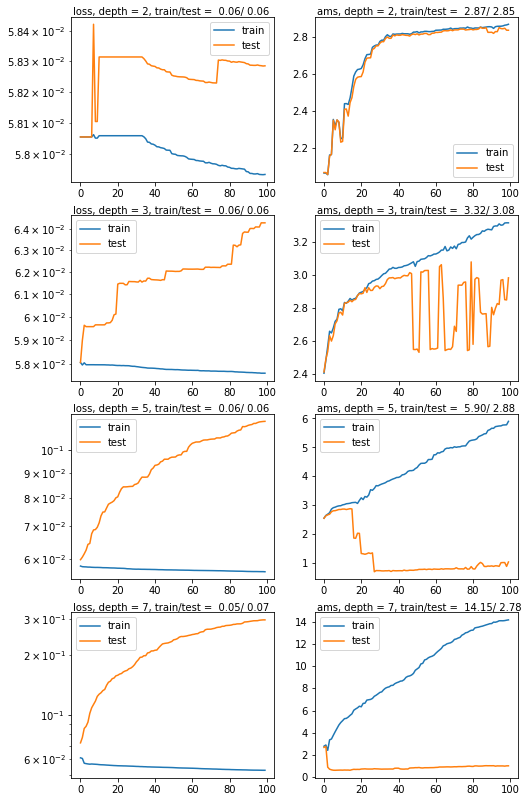

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

fig = plt.figure(figsize=(8, 14))
for i, depth in enumerate([2, 3, 5, 7]):
    ax = fig.add_subplot(4, 2, 1 + 2 * i + 0)

    model = GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        n_estimators=100,
        subsample=1.0,
        criterion='friedman_mse',
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=depth,
        max_features=X_train.shape[1],
        validation_fraction=0.1,
        n_iter_no_change=None,
        random_state=1,
        verbose=0,
    )

    # フィット
    print(f'model fitting, depth = {depth}')
    _ = model.fit(X_train, Y_train, W_train)

    # Loss history
    loss_train = get_loss_history(model, X_train, Y_train, W_train)
    loss_test = get_loss_history(model, X_test, Y_test, W_test)

    ax.plot(loss_train, label='train')
    ax.plot(loss_test, label='test')
    ax.set_yscale('log')
    ax.legend()
    ax.text(0.01, 1.01, f'loss, depth = {depth}, train/test = {min(loss_train): 2.2f}/{min(loss_test): 2.2f}', transform=ax.transAxes)

    ax = fig.add_subplot(4, 2, 1 + 2 * i + 1)

    ams_train, ams_test = get_ams_history(model, X_train, Y_train, W_train, X_test, Y_test, W_test)

    ax.plot(ams_train, label='train')
    ax.plot(ams_test, label='test')
    ax.legend()
    ax.text(0.01, 1.01, f'ams, depth = {depth}, train/test = {max(ams_train): 2.2f}/{max(ams_test): 2.2f}', transform=ax.transAxes)

plt.show()

# Histogram based BDT
LightGBMを元に作成された高速なGradientBoostingClassifierです。

model fitting, depth = 2
model fitting, depth = 3
model fitting, depth = 5
model fitting, depth = 7


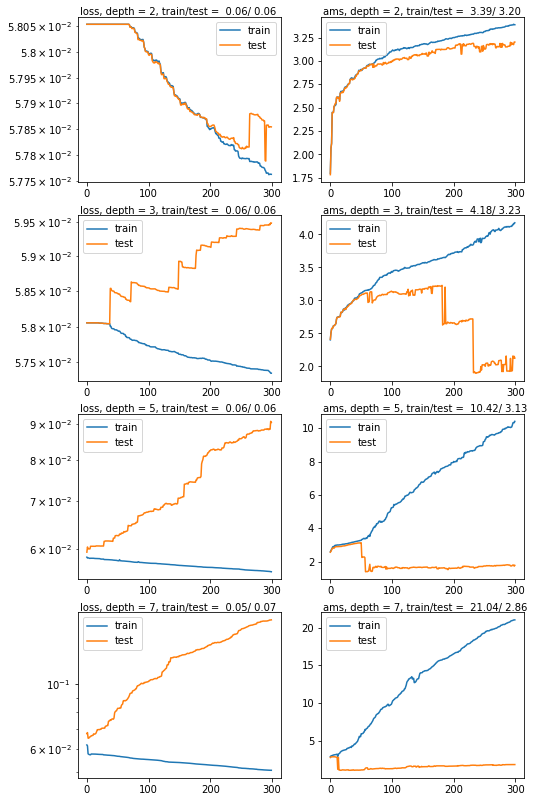

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier

fig = plt.figure(figsize=(8, 14))
for i, depth in enumerate([2, 3, 5, 7]):
    ax = fig.add_subplot(4, 2, 1 + 2 * i + 0)

    model = HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        max_iter=300,
        max_leaf_nodes=None,
        max_depth=depth,
        min_samples_leaf=1,
        early_stopping=False,
        validation_fraction=0.1,
        n_iter_no_change=0,
        random_state=1,
        verbose=0,
    )

    # フィット
    print(f'model fitting, depth = {depth}')
    _ = model.fit(X_train, Y_train, W_train)

    # Loss history
    loss_train = get_loss_history(model, X_train, Y_train, W_train)
    loss_test = get_loss_history(model, X_test, Y_test, W_test)

    ax.plot(loss_train, label='train')
    ax.plot(loss_test, label='test')
    ax.set_yscale('log')
    ax.legend()
    ax.text(0.01, 1.01, f'loss, depth = {depth}, train/test = {min(loss_train): 2.2f}/{min(loss_test): 2.2f}', transform=ax.transAxes)

    ax = fig.add_subplot(4, 2, 1 + 2 * i + 1)

    ams_train, ams_test = get_ams_history(model, X_train, Y_train, W_train, X_test, Y_test, W_test)

    ax.plot(ams_train, label='train')
    ax.plot(ams_test, label='test')
    # ax.set_yscale('log')
    ax.legend()
    ax.text(0.01, 1.01, f'ams, depth = {depth}, train/test = {max(ams_train): 2.2f}/{max(ams_test): 2.2f}', transform=ax.transAxes)

plt.show()
